# Real Estate Value Predictor Model
# General Assembly Data Science Class, Final Project
# By Simon Mettler
###  Welcome. This document will walk through the process of compiling the necessary datasets and the conducting of preliminary analyses, followed by the actual models/regressions


## Step 1: Importing all necessary modules


In [858]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import neighbors, metrics, grid_search, cross_validation

## Step 2: Loading Required data
### This analysis will employ several datasets. Some can be downloaded "as is" from NYC's open data portal, others have been created by intermediaries, while yet others will require some effort to create/normalize

### Dataset A: DOF Records
#### The first datasets to use can be downloaded from the link here <http://chriswhong.com/open-data/liberating-data-from-nyc-property-tax-bills/> ,  this file contains the data for the dependent variable. Normally, this data is not released in a single flat file by the Department of Finance, but several civic hackers have taken it upon themselves to release all of the tax info, including estimated market value, at the "lot level" (e.g. for every parcel of land in NYC)

In [832]:
data=pd.read_csv('tax_bills_june15_bbls.csv')
# this loads the dataset that can be downloaded from the website

In [402]:
# Go ahead and explore the data to make sure it's imported correctly- it should be >1M rows
data.head()

,bbl,ownername,address,taxclass,taxrate,emv,tbea,bav,tba,propertytax,condonumber,condo
0,1000010010,GOVERNORS ISLAND CORPORATION,GOVERNORS ISLAND CORPORATION\nC/O TRUST FOR. G...,4 - commercial property,10.6840%,337672000.0,15749050.0,147407802.0,NaN,0.0,NaN,NaN
1,1000010101,U. S. GOVT LAND & BLDGS,"BEDLOES ISLAND\n1 LIBERTY ISLAND\nELLIS ISLAND,",4 - commercial property,10.6840%,25607000.0,1106496.0,10356570.0,NaN,0.0,NaN,NaN
2,1000010201,U. S. GOVT LAND & BLDGS,"ELLIS ISLAND\n1 LIBERTY ISLAND\nELLIS ISLAND,",4 - commercial property,10.6840%,233982000.0,10366655.0,97029720.0,NaN,0.0,NaN,NaN
3,1000020001,NYC DSBS,"NYC DSBS\n110 WILLIAM ST. FL. 7\nNEW YORK , NY...",4 - commercial property,10.6840%,69458000.0,3163690.0,29611473.0,NaN,0.0,NaN,NaN
4,1000020002,"10 SSA LANDLORD, LLC","10 SSA LANDLORD, LLC\n729 7TH AVE. FL. 15\nNEW...",4 - commercial property,10.6840%,55592000.0,2672762.0,25016491.0,654246.0,654246.0,NaN,NaN


In [403]:
news=data.bbl.unique()

In [404]:
len(news)

1081624

In [7]:
data.propertytax.mean()

20120.8435694815

In [8]:
data.bav.mean()

268107.262703244

### Dataset B: MAPPLUTO
#### MapPLUTO is NYC's "master land use dataset"- a trove of information about the built environment. In essence, it categorizes the entire city into entitites known as BBLs (Borough Block Lot), which are essentially parcels of land; each of these BBLs receives a unique code, and has data associated with it, including but not limited to the financial information imported in dataset A. The dataset is available here: <http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page> The file is quite large, and so in my case I chose to download smaller datasets containing the same information for each borough, and then imported it from 5 different borough-level CSV files. PLUTO has many columns, in the below I only import what we may end up needing for the analysis

In [405]:
# Note the columns selected in the below- these are a subset of all of the columns in PLUTO
# the below imports the CSV for all of the Manhattan data only
Manhattan=pd.read_csv('Pluto_MN.csv',usecols=["BBL",'BldgArea','Borough','BoroCode','BsmtCode','BuiltCode','BuiltFAR','CB2010','CT2010','HistDist','Landmark','LotArea','NumFloors',"LandUse",'OwnerName','OwnerType','IrrLotCode','PolicePrct','ResidFAR','RetailArea','SchoolDist','Tract2010','UnitsRes','UnitsTotal','YearBuilt'])

In [406]:
Manhattan.head()

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,BsmtCode,YearBuilt,BuiltCode,HistDist,Landmark,BuiltFAR,ResidFAR,BoroCode,BBL,Tract2010
0,MN,5.0,1018.0,2.0,1.0,8.0,P,GOVERNORS ISLAND CORP,7736692,2725731,...,5.0,1900,E,Governors Island Historic District,THE GOVERNOR'S ISLAND,0.35,0.6,1,1000010010,5
1,MN,1.0,1001.0,2.0,1.0,8.0,X,U S GOVT LAND & BLDGS,541886,541886,...,5.0,1900,E,NaN,STATUE OF LIBERTY NATIONAL MONUMENT,1.00,0.6,1,1000010101,1
2,MN,1.0,1000.0,2.0,1.0,NaN,X,U S GOVT LAND & BLDGS,2764190,603130,...,5.0,1900,E,Ellis Island Historic District,NaN,0.22,0.6,1,1000010201,1
3,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,5.0,0,NaN,NaN,NaN,0.00,0.0,1,1000010301,0
4,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,5.0,0,NaN,NaN,NaN,0.00,0.0,1,1000010401,0


In [407]:
# Imports the Brooklyn data
Brooklyn=pd.read_csv('Pluto_BK.csv',usecols=["BBL",'BldgArea','Borough','BoroCode','BsmtCode','BuiltCode','BuiltFAR','CB2010','CT2010','HistDist','Landmark','LotArea','NumFloors',"LandUse",'OwnerName','OwnerType','IrrLotCode','PolicePrct','ResidFAR','RetailArea','SchoolDist','Tract2010','UnitsRes','UnitsTotal','YearBuilt'])

In [408]:
# Imports the Bronx data
Bronx=pd.read_csv('Pluto_BX.csv',usecols=["BBL",'BldgArea','Borough','BoroCode','BsmtCode','BuiltCode','BuiltFAR','CB2010','CT2010','HistDist','Landmark','LotArea','NumFloors',"LandUse",'OwnerName','OwnerType','IrrLotCode','PolicePrct','ResidFAR','RetailArea','SchoolDist','Tract2010','UnitsRes','UnitsTotal','YearBuilt'])

In [409]:
# Imports the Queens data
Queens=pd.read_csv('Pluto_QN.csv',usecols=["BBL",'BldgArea','Borough','BoroCode','BsmtCode','BuiltCode','BuiltFAR','CB2010','CT2010','HistDist','Landmark','LotArea','NumFloors',"LandUse",'OwnerName','OwnerType','IrrLotCode','PolicePrct','ResidFAR','RetailArea','SchoolDist','Tract2010','UnitsRes','UnitsTotal','YearBuilt'])

In [410]:
# Imports the Staten Island data
SIsland=pd.read_csv('Pluto_SI.csv',usecols=["BBL",'BldgArea','Borough','BoroCode','BsmtCode','BuiltCode','BuiltFAR','CB2010','CT2010','HistDist','Landmark','LotArea','NumFloors',"LandUse",'OwnerName','OwnerType','IrrLotCode','PolicePrct','ResidFAR','RetailArea','SchoolDist','Tract2010','UnitsRes','UnitsTotal','YearBuilt'])

In [411]:
# Combines all of the datasets into one
Alls=[Manhattan,Brooklyn,Bronx,Queens,SIsland]
Pluto_all=pd.concat(Alls)

In [833]:
# sense check that the length of the joined dataset is correct- it should be ~800k rows
len(Pluto_all)

859205

In [452]:
Pluto_all.head()

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,BsmtCode,YearBuilt,BuiltCode,HistDist,Landmark,BuiltFAR,ResidFAR,BoroCode,BBL,Tract2010
0,MN,5.0,1018.0,2.0,1.0,8.0,P,GOVERNORS ISLAND CORP,7736692,2725731,...,5.0,1900,E,Governors Island Historic District,THE GOVERNOR'S ISLAND,0.35,0.6,1,1000010010,5
1,MN,1.0,1001.0,2.0,1.0,8.0,X,U S GOVT LAND & BLDGS,541886,541886,...,5.0,1900,E,NaN,STATUE OF LIBERTY NATIONAL MONUMENT,1.00,0.6,1,1000010101,1
2,MN,1.0,1000.0,2.0,1.0,NaN,X,U S GOVT LAND & BLDGS,2764190,603130,...,5.0,1900,E,Ellis Island Historic District,NaN,0.22,0.6,1,1000010201,1
3,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,5.0,0,NaN,NaN,NaN,0.00,0.0,1,1000010301,0
4,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,5.0,0,NaN,NaN,NaN,0.00,0.0,1,1000010401,0


### Joining datasets A and B, and scrubbing them for missing values or otherwise corrupted data rows
#### This is an important process- since there is such a wealth of information, we want to elimiante certain buildings to get at residential properties that can be considered "apples to apples"

In [834]:
# Join the two datasets together- this needs to be a left join, since we want a single entry for each bbls (some condos are treated as duplicate entries, but their info is generally similar)
plutojoined=pd.merge(left=Pluto_all, right=data, how='left',left_on='BBL',right_on='bbl')

In [455]:
# need to identify missing values to drop
plutojoined.condo.unique()

array([nan, 'lot', 'unit'], dtype=object)

In [456]:
plutojoined.condo.describe()

count     8303
unique       2
top        lot
freq      5872
Name: condo, dtype: object

In [457]:
plutojoined.head()
# join tax lots data to PLUTO data

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,address,taxclass,taxrate,emv,tbea,bav,tba,propertytax,condonumber,condo
0,MN,5.0,1018.0,2.0,1.0,8.0,P,GOVERNORS ISLAND CORP,7736692,2725731,...,GOVERNORS ISLAND CORPORATION\nC/O TRUST FOR. G...,4 - commercial property,10.6840%,337672000.0,15749050.0,147407802.0,NaN,0.0,NaN,NaN
1,MN,1.0,1001.0,2.0,1.0,8.0,X,U S GOVT LAND & BLDGS,541886,541886,...,"BEDLOES ISLAND\n1 LIBERTY ISLAND\nELLIS ISLAND,",4 - commercial property,10.6840%,25607000.0,1106496.0,10356570.0,NaN,0.0,NaN,NaN
2,MN,1.0,1000.0,2.0,1.0,NaN,X,U S GOVT LAND & BLDGS,2764190,603130,...,"ELLIS ISLAND\n1 LIBERTY ISLAND\nELLIS ISLAND,",4 - commercial property,10.6840%,233982000.0,10366655.0,97029720.0,NaN,0.0,NaN,NaN
3,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [460]:
plutojoined.condo.fillna(0,inplace=True)

In [458]:
plutojoined.head()

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,address,taxclass,taxrate,emv,tbea,bav,tba,propertytax,condonumber,condo
0,MN,5.0,1018.0,2.0,1.0,8.0,P,GOVERNORS ISLAND CORP,7736692,2725731,...,GOVERNORS ISLAND CORPORATION\nC/O TRUST FOR. G...,4 - commercial property,10.6840%,337672000.0,15749050.0,147407802.0,NaN,0.0,NaN,NaN
1,MN,1.0,1001.0,2.0,1.0,8.0,X,U S GOVT LAND & BLDGS,541886,541886,...,"BEDLOES ISLAND\n1 LIBERTY ISLAND\nELLIS ISLAND,",4 - commercial property,10.6840%,25607000.0,1106496.0,10356570.0,NaN,0.0,NaN,NaN
2,MN,1.0,1000.0,2.0,1.0,NaN,X,U S GOVT LAND & BLDGS,2764190,603130,...,"ELLIS ISLAND\n1 LIBERTY ISLAND\nELLIS ISLAND,",4 - commercial property,10.6840%,233982000.0,10366655.0,97029720.0,NaN,0.0,NaN,NaN
3,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MN,NaN,NaN,2.0,1.0,7.0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [459]:
plutojoined.condo.describe()

count     8303
unique       2
top        lot
freq      5872
Name: condo, dtype: object

In [461]:
# drop all condo buildings since these are treated differently- could look at these in a separate analysis but will ignore for now
plutojoined=plutojoined[plutojoined['condo']==0]

In [462]:
len(plutojoined)


850902

In [463]:
print plutojoined.emv.mean()

1240794.54041


In [464]:
#make this new joined dataset the principal dataframe
df=plutojoined

In [426]:
df.describe()

,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,LotArea,BldgArea,RetailArea,NumFloors,UnitsRes,...,BoroCode,BBL,Tract2010,bbl,emv,tbea,bav,tba,propertytax,condonumber
count,854914.000000,837821.000000,856111.000000,856002.000000,856080.000000,8.592050e+05,8.592050e+05,8.592050e+05,859205.000000,859205.000000,...,859205.000000,8.592050e+05,859205.000000,8.497140e+05,8.424960e+05,8.435240e+05,8.435240e+05,8.151860e+05,8.435240e+05,5877.000000
mean,462.411985,2056.305420,22.006028,86.864827,2.167741,7.876288e+03,6.375135e+03,3.189153e+02,2.313824,4.110628,...,3.461342,3.514391e+09,9256.931927,3.522671e+09,1.239876e+06,3.547897e+04,2.958699e+05,2.325662e+04,2.193349e+04,1243.793602
std,376.915727,1154.473709,7.995537,29.404356,2.415610,3.702427e+05,8.040079e+04,6.321360e+03,1.954136,38.880971,...,1.023638,1.031782e+09,26275.144920,1.027729e+09,2.249131e+07,9.875930e+05,9.210106e+06,3.164390e+05,3.086531e+05,914.607726
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,1.000000,1.000010e+09,0.000000,1.000010e+09,1.000000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000
25%,170.000000,1004.000000,17.000000,66.000000,1.000000,2.000000e+03,1.366000e+03,0.000000e+00,2.000000,1.000000,...,3.000000,3.031310e+09,207.000000,3.032650e+09,3.990000e+05,4.070000e+03,2.142000e+04,3.606000e+03,3.432750e+03,451.000000
50%,351.000000,2001.000000,24.000000,102.000000,1.000000,2.517000e+03,1.994000e+03,0.000000e+00,2.000000,2.000000,...,4.000000,4.008470e+09,484.000000,4.008890e+09,5.340000e+05,5.324000e+03,2.811100e+04,4.891000e+03,4.785000e+03,1102.000000
75%,662.000000,3000.000000,29.000000,111.000000,2.000000,4.000000e+03,3.000000e+03,0.000000e+00,2.500000,2.000000,...,4.000000,4.106310e+09,1120.000000,4.106570e+09,7.770000e+05,7.644000e+03,4.198800e+04,7.033000e+03,6.884000e+03,1934.000000
max,9901.000000,9003.000000,32.000000,123.000000,11.000000,2.147557e+08,4.954783e+07,2.644824e+06,119.000000,13248.000000,...,5.000000,5.080500e+09,157903.000000,5.080500e+09,1.457087e+10,6.281640e+08,5.879484e+09,6.733982e+07,6.733982e+07,9566.000000


In [465]:
print df.columns

Index([u'Borough', u'CT2010', u'CB2010', u'SchoolDist', u'PolicePrct',
       u'LandUse', u'OwnerType', u'OwnerName', u'LotArea', u'BldgArea',
       u'RetailArea', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'IrrLotCode',
       u'BsmtCode', u'YearBuilt', u'BuiltCode', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'BoroCode', u'BBL', u'Tract2010', u'bbl',
       u'ownername', u'address', u'taxclass', u'taxrate', u'emv', u'tbea',
       u'bav', u'tba', u'propertytax', u'condonumber', u'condo'],
      dtype='object')


#### The LandUse column identifies what types of uses exist- we want to restrict it to categories 1-4, which are the residential uses- commercial uses would of course also make for an interesting analysis, but that would be a separate effort with separate drivers to identify

In [467]:
df.LandUse.unique()

array([  8.,  nan,   7.,   9.,   5.,   4.,   3.,  11.,  10.,   6.,   2.,
         1.])

In [468]:
df.LandUse=df.LandUse.astype(str)

In [470]:
df.LandUse.unique()

array(['8.0', 'nan', '7.0', '9.0', '5.0', '4.0', '3.0', '11.0', '10.0',
       '6.0', '2.0', '1.0'], dtype=object)

In [471]:
df=df[df["LandUse"].str.contains('1.0' or '2.0' or '3.0' or '4.0')]
## limit to landuse types 01-04 codes, which are the ones that contain residential

In [472]:
len(df)

591208

#### The BuiltFAR column identifies how much floor area ratio is actually built out on a given parcel- a floor area ratio of 0 implies that a property is unbuilt, and should be removed from our analysis

In [473]:
df=df[df['BuiltFAR']>0]
## limit only to lots that have property on them (e.g. eliminate empty lots)

In [474]:
len(df)

563383

#### The RetailArea column identifies buildings that have ground floor retail or otherwise have retail in the building- while interesting, these buildings would skew the analysis and are therefore removed

In [475]:
df.RetailArea.unique()

array([   0, 1011, 1249, 1122, 1000, 1275])

In [476]:
df=df[df['RetailArea']==0]
#limit out buildings with retail in them

In [477]:
len(df)

563378

### After all of this cleaning, we have a dataframe with our main dependent variable, as well as with various pieces of information that will either be used directly, or as part of a calculation or a lookup table, as independent variables. We are left with ~ 560,000 rows of data

### Before adding any additional datasets, we can already explore our existing data. The dependent variable that we are after is in the column emv, which stands for estimated market value- this is a figure that the Department of Finance calculates for every lot. In addition, several potential independent variables that can be directly derived from this dataset include:
1. The square footage of building built on the land (column BldgArea
2. The age of the building (based on YearBuilt, which will need to become a calculated field)
2. Whether or not the lot is landmarked or in a historic district
2. Which Borough the building is in

#### 1. Let's look at the effect of square footage on EMV

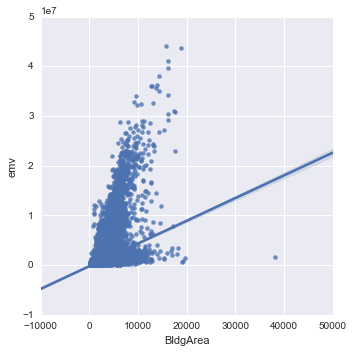

In [865]:
sns.lmplot('BldgArea',"emv",df)

In [869]:
from scipy.stats.stats import pearsonr   
print pearsonr(df.BldgArea,(df.emv))

(0.4768512215731221, 0.0)


#### It appears that there is a definite positive correlation betwen BldgArea and emv, although it doesn't appear directly linear

#### 2. Now let's look at the effect of historic districts and landmarked buildings on emv

In [502]:
# Create binaries for whether a lot is in a historic district or not, and landmarked or not
df['ishist']=df.HistDist.notnull()
df['islandmark']=df.Landmark.notnull()

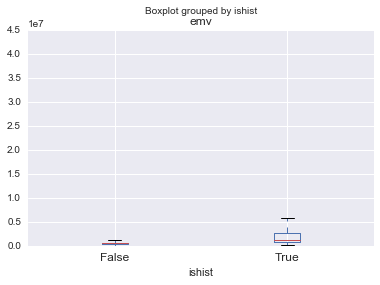

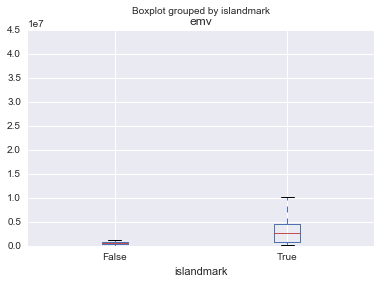

In [864]:
df.boxplot(column='emv', by='ishist', fontsize=12)
df.boxplot(column='emv', by='islandmark')

#### It looks as though being in a historic district, or being landmarked, moves both the median value as well as the upper outliers/bounds significantly

#### 3. Now, let's look at whether the age of a building has an effect on its value- this data is a little trickier since a building's age can cut both ways, and since internal (gut) renovations don't always show up in the data

In [504]:
# convert year build of the building into a number that can be used in regression
df['buildingage']=2016.0-df.YearBuilt

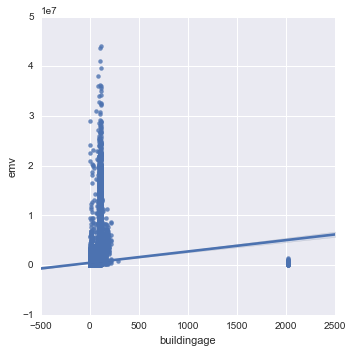

In [874]:
sns.lmplot('buildingage',"emv",df)

In [877]:
## looks like some values in the above are skewing the data- buildings shouldn't be older than 400 years old- that's impossible
len(df[df['buildingage']>400])

49

In [878]:
df=df[df['buildingage']<400]

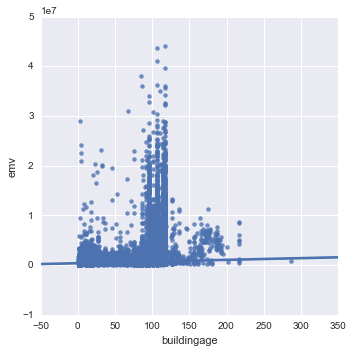

In [880]:
sns.lmplot('buildingage',"emv",df)

In [884]:
print pearsonr(df.buildingage,df.emv)

(0.12407658253628444, 0.0)


#### So looks like a fairly week positive correlation between building age and EMV, but with the data all over the place- it may not be worth including this variable in the final analysis

#### 4. Lastly, before we import any other external datasets, let's look at the effect that each borough has on the estimated market value. Obviously, there is widespread variation within boroughs as well, but this is a good place to start- each borough needs to be turned into its own dummy to use in an eventual regression

In [499]:
boroughdummies=pd.get_dummies(df.Borough, prefix='is', prefix_sep='_')
df=pd.concat([df,pd.get_dummies(df.Borough, prefix='is', prefix_sep='_')],axis=1)
## turns the borough variable into 5 dummies for the regression

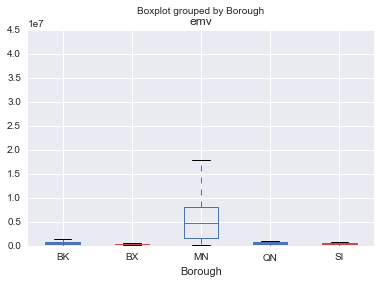

In [882]:
df.boxplot(column='emv', by='Borough')

#### Looks like Manhattan has a much larger distribution of values, as well as much higher median prices. This makes sense, since buildings in Manhattan tend to be larger, and more valuable

## Dataset C- External Datasets to use
### Several other indicators can be used that likely help to predict property values. Top of mind are things like crime, the quality of schools, and demographic data like race and median income. The issue with these data is two-fold: First, it is difficult to agree on the right indicators to use (e.g crime rate vs. violent crime rate vs. absolute # of crimes committed are three very different variables); and second, the units of analysis at which indicators are tracked vary. Therefore, calculations about indicators must be considered with these difficulties in mind

### A) Police Data. The dataset indicates which police precint every bbbl is in, and the city reports a "crime rate" (which is already normalized, as it is the total major crimes divided by a precint's population) for each precinct. In the absence of more granular crime data, this will serve as a proxy for safety/crime levels in a given area

In [885]:
# import police crime data as proxy for safety in neighborhood- the CSV is a modified version of a file available on the police department's webiste
police=pd.read_csv('Police_data.csv')


In [485]:
police.head()

,Police Precinct,Population in precinct,Total major crimes 2015,Crime Rate 2015
0,1,66679,1446,21.685988
1,5,52568,917,17.444072
2,6,62226,1521,24.443159
3,7,56355,781,13.858575
4,9,76443,1337,17.490156


In [494]:
dfwpolice=pd.merge(left=df, right=police, how='left',left_on='PolicePrct',right_on='Police Precinct')
# join police data

In [495]:
dfwpolice.head()

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,tba,propertytax,condonumber,condo,School District,4 Year August Graduation Rate,Police Precinct,Population in precinct,Total major crimes 2015,Crime Rate 2015
0,MN,15.01,3014.0,2.0,1.0,1.0,P,"136 BEEKMAN, LLC",477,1900,...,11232.0,11232.0,NaN,0,2.0,0.74564,1.0,66679.0,1446.0,21.685988
1,MN,15.01,3014.0,2.0,1.0,1.0,NaN,TITOCITY1990 LLC,458,1845,...,22676.0,22676.0,NaN,0,2.0,0.74564,1.0,66679.0,1446.0,21.685988
2,MN,15.01,3014.0,2.0,1.0,1.0,NaN,"LEVINE,JOSHUA",2820,13015,...,59112.0,59112.0,NaN,0,2.0,0.74564,1.0,66679.0,1446.0,21.685988
3,MN,15.01,3014.0,2.0,1.0,1.0,NaN,"BURROW, CLIVE",469,1880,...,10295.0,10295.0,NaN,0,2.0,0.74564,1.0,66679.0,1446.0,21.685988
4,MN,21.00,1002.0,2.0,1.0,1.0,NaN,"24-26 WARREN, LLC.",2523,11515,...,29158.0,29158.0,NaN,0,2.0,0.74564,1.0,66679.0,1446.0,21.685988


In [496]:
dfwpolice.rename(columns={'Crime Rate 2015':'crime_rate'})

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,tba,propertytax,condonumber,condo,School District,4 Year August Graduation Rate,Police Precinct,Population in precinct,Total major crimes 2015,crimerate
0,MN,15.01,3014.0,2.0,1.0,1.0,P,"136 BEEKMAN, LLC",477,1900,...,11232.0,11232.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
1,MN,15.01,3014.0,2.0,1.0,1.0,NaN,TITOCITY1990 LLC,458,1845,...,22676.0,22676.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
2,MN,15.01,3014.0,2.0,1.0,1.0,NaN,"LEVINE,JOSHUA",2820,13015,...,59112.0,59112.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
3,MN,15.01,3014.0,2.0,1.0,1.0,NaN,"BURROW, CLIVE",469,1880,...,10295.0,10295.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
4,MN,21.00,1002.0,2.0,1.0,1.0,NaN,"24-26 WARREN, LLC.",2523,11515,...,29158.0,29158.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
5,MN,21.00,2000.0,2.0,1.0,1.0,P,145 READE STREET,1766,11913,...,82758.0,82758.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
6,MN,39.00,4010.0,2.0,1.0,1.0,NaN,"LIM, LAUREEN",1350,5300,...,41772.0,41772.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
7,MN,39.00,4010.0,2.0,1.0,1.0,NaN,HUMBO JUMBO LLC,1370,6800,...,78951.0,78951.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
8,MN,39.00,4010.0,2.0,1.0,1.0,NaN,"MASTERS, BLYTHE S.J.",1356,6250,...,79448.0,79448.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988
9,MN,39.00,4010.0,2.0,1.0,1.0,NaN,"PANG, ELAINE M",1350,6750,...,79678.0,79678.0,NaN,0,2.0,0.745640,1.0,66679.0,1446.0,21.685988


In [497]:
df=dfwpolice
# update dataaframe to include police data as well

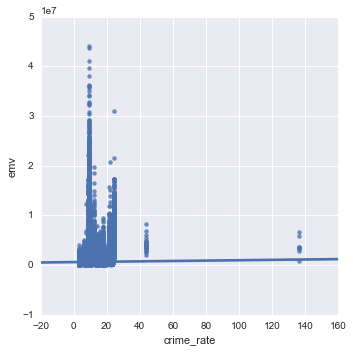

In [889]:
sns.lmplot('crime_rate',"emv",df)

#### Because of the way crime data clusters, it seems difficult to draw any direct correlation coefficient conclusions, but it does appear that the highest property values appear in neighborhoods with less crime 

### B) School quality data: Presumably, the quality of local schools could have an effect on property values. However,it is notoriously difficult to capture the quality of all schools, especially in a single number. As a proxy, we will use the 4 year august graduation rate in a given school district

In [890]:
schools=pd.read_csv('SCA_proxy_data.csv')
#join schools data as proxy for school quality in neighborhood- this data is a modified table of what is available on DOE/SCA websites

In [486]:
schools.head()

,School District,Cohort Year,Cohort Category,Students,Total grads,4 Year August Graduation Rate
0,1,2011,4 Year August,1128,665,0.589539
1,2,2011,4 Year August,8716,6499,0.745640
2,3,2011,4 Year August,2425,1825,0.752577
3,4,2011,4 Year August,850,690,0.811765
4,5,2011,4 Year August,1002,650,0.648703


In [487]:
dfwschools=pd.merge(left=df, right=schools, how='left',left_on='SchoolDist',right_on='School District')

In [488]:
dfwschools=dfwschools.drop(['Students'],axis=1)

In [489]:
dfwschools=dfwschools.drop(['Cohort Year', 'Cohort Category', 'Total grads'],axis=1)
# drop unnecessary columns

In [490]:
dfwschools.rename(columns={"4 Year August Graduation Rate":"school_grad_rate"})

,Borough,CT2010,CB2010,SchoolDist,PolicePrct,LandUse,OwnerType,OwnerName,LotArea,BldgArea,...,taxrate,emv,tbea,bav,tba,propertytax,condonumber,condo,School District,schoolgradscore
0,MN,15.01,3014.0,2.0,1.0,1.0,P,"136 BEEKMAN, LLC",477,1900,...,19.1570%,1983000.0,11232.0,58633.0,11232.0,11232.0,NaN,0,2.0,0.745640
1,MN,15.01,3014.0,2.0,1.0,1.0,NaN,TITOCITY1990 LLC,458,1845,...,19.1570%,2424000.0,22676.0,118368.0,22676.0,22676.0,NaN,0,2.0,0.745640
2,MN,15.01,3014.0,2.0,1.0,1.0,NaN,"LEVINE,JOSHUA",2820,13015,...,19.1570%,8644000.0,65241.0,340560.0,59112.0,59112.0,NaN,0,2.0,0.745640
3,MN,15.01,3014.0,2.0,1.0,1.0,NaN,"BURROW, CLIVE",469,1880,...,19.1570%,1955000.0,10597.0,55315.0,10295.0,10295.0,NaN,0,2.0,0.745640
4,MN,21.00,1002.0,2.0,1.0,1.0,NaN,"24-26 WARREN, LLC.",2523,11515,...,19.1570%,9104000.0,29158.0,152207.0,29158.0,29158.0,NaN,0,2.0,0.745640
5,MN,21.00,2000.0,2.0,1.0,1.0,P,145 READE STREET,1766,11913,...,19.1570%,7400000.0,82758.0,432000.0,82758.0,82758.0,NaN,0,2.0,0.745640
6,MN,39.00,4010.0,2.0,1.0,1.0,NaN,"LIM, LAUREEN",1350,5300,...,19.1570%,7377000.0,41772.0,218052.0,41772.0,41772.0,NaN,0,2.0,0.745640
7,MN,39.00,4010.0,2.0,1.0,1.0,NaN,HUMBO JUMBO LLC,1370,6800,...,19.1570%,6899000.0,78951.0,412128.0,78951.0,78951.0,NaN,0,2.0,0.745640
8,MN,39.00,4010.0,2.0,1.0,1.0,NaN,"MASTERS, BLYTHE S.J.",1356,6250,...,19.1570%,9143000.0,79448.0,414720.0,79448.0,79448.0,NaN,0,2.0,0.745640
9,MN,39.00,4010.0,2.0,1.0,1.0,NaN,"PANG, ELAINE M",1350,6750,...,19.1570%,7681000.0,79678.0,415920.0,79678.0,79678.0,NaN,0,2.0,0.745640


In [491]:
len(dfwschools)

563378

In [492]:
df=dfwschools

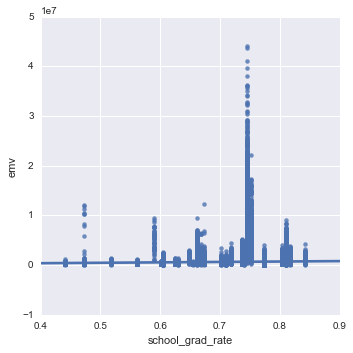

In [893]:
sns.lmplot('school_grad_rate',"emv",df)

#### Again, it seems difficult to establish a direct linear relationship, but it seems as though higher property values tend to concentrate in school districts with higher graduation rates

### For various other variables, the unit of analysis is something known as an NTA- neighborhood tabulation area- this is used by the census bureau and other statistical bureaus to standardize units of analysis. Information from the census, and from surveys like the ACS, is tracked at that level. The PLUTO dataset shows the census tract for each given bbl, so we need an equivalency that tells us the NTA that each census tract is associated with

In [543]:
# this data is readily available, easiest to copy from an excel table
equivalency=pd.read_clipboard()

In [545]:
equivalency['float']=equivalency.Tract.astype(float)

In [506]:
df['censustract']=df.CT2010*100

In [551]:
testjoin=pd.merge(left=df, right=equivalency, how='left',left_on=['censustract','Borough'],right_on=['float','Borough'])

In [553]:
df=pd.concat([df,testjoin.NTA],axis=1)

### C) Race Data. Again, to use a proxy, we use a single number, the % of a given NTA that is white, as per census bureau data. 

In [349]:
race=pd.read_clipboard()

In [894]:
race.head()

,NTA,perc_white
0,BK72,0.9250030462
1,BK73,0.7845235511
2,BK76,0.8546729268
3,BK90,0.6253053838
4,BK09,0.800493659


In [655]:
racejoin=pd.merge(left=df, right=race, how='left',left_on='NTA',right_on='NTA')

In [657]:
df=pd.concat([df,racejoin.perc_white],axis=1)

In [898]:
df.perc_white.head()

1    0.7060736949
2    0.7060736949
3    0.7060736949
4    0.6906313188
5    0.6906313188
Name: perc_white, dtype: object

In [913]:
df.perc_white=df.perc_white.astype(float)

(0.17349382152059223, 0.0)


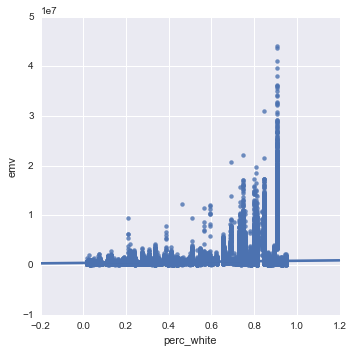

In [914]:
print pearsonr(df.perc_white,df.emv)
sns.lmplot('perc_white','emv',df)

### Again, the direct linear relationship appears weak but existent- the less diverse a neighborhood, the higher the cluster of high-value properties in it

### D) Income Data- again, this is from the census data- we use median income in the NTA as a proxy

In [391]:
income=pd.read_clipboard()

In [903]:
income.head()

,NTA,Med_Income
0,BK09,105398.0
1,BK17,51314.0
2,BK19,30872.0
3,BK21,23229.0
4,BK23,38047.0


In [558]:
incomejoin=pd.merge(left=df, right=income, how='left',left_on='NTA',right_on='NTA')

In [560]:
df=pd.concat([df,incomejoin.Med_Income],axis=1)

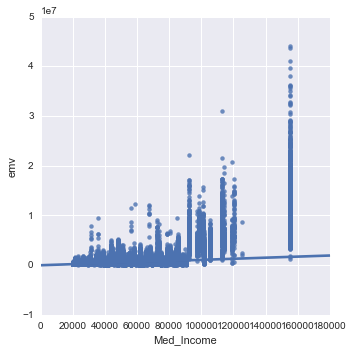

In [902]:
sns.lmplot('Med_Income','emv',df)

#### Again, this appears like a weak correlation, but it does seem as though the areas with the highests emvs are clustered in areas w/ higher median incomes

## Dataset D- data about proximity to subway
### As previously explained, this data requires some external processing in order to obtain. Specifically, it requires some geospatial analysis, as every bbl that is within a certain geography needs to be counted and categorized. This external analysis was conducted in cartodb, using the shape files here <https://cwhong.carto.com/tables/combined/public/map>  and the geo-referenced mappluto file to create lists of bbls within 300, 450, and 600 seconds (5, 7.5, and 10 min) of a subway stop. These were in CSV format and imported accordingly

In [394]:
map300=pd.read_csv('300CSV.csv')

In [395]:
map300.head()

,bbl,time
0,1008610032,300
1,1008610044,300
2,1008610047,300
3,1008610049,300
4,1008610052,300


In [568]:
join300=pd.merge(left=df, right=map300, how='left',left_on='BBL',right_on='bbl')

In [569]:
len(join300)

563378

In [396]:
map450=pd.read_csv('450CSV.csv')

In [572]:
map450.bbl.drop_duplicates(inplace=True)

In [573]:
join450=pd.merge(left=df, right=map450, how='left',left_on='BBL',right_on='bbl')

In [574]:
len(join450)

563378

In [397]:
map600=pd.read_csv('600CSV.csv')

In [575]:
map600.bbl.drop_duplicates(inplace=True)

In [578]:
join600=pd.merge(left=df, right=map600, how='left',left_on='BBL',right_on='bbl')

In [579]:
len(join600)

563378

In [580]:
df=pd.concat([df,join300.time],axis=1)

In [581]:
len(df)

563378

In [586]:
df.rename(columns={'time':'within300'},inplace=True)

In [590]:
df=pd.concat([df,join450.time],axis=1)

In [591]:
df.rename(columns={'time':'within450'},inplace=True)

In [594]:
len(df[df.within450==450])

13538

In [595]:
df=pd.concat([df,join600.time],axis=1)

In [596]:
df.rename(columns={'time':'within600'},inplace=True)

In [599]:
len(df[df.within600==600])

34276

In [601]:
df.within300.fillna(0,inplace=True)

In [602]:
df.within450.fillna(0,inplace=True)

In [603]:
df.within600.fillna(0,inplace=True)

In [633]:
df.within300.replace(to_replace=300,value=1,inplace=True)

In [636]:
df.within450.replace(to_replace=450,value=1,inplace=True)

In [637]:
df.within600.replace(to_replace=600,value=1,inplace=True)

In [642]:
df['within450excl'][df.within450==df.within300]=0

/Users/simonmettler/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [646]:
df.within300.sum()

1071.0

In [645]:
df.within450.sum()

13538.0

In [644]:
df.within450excl.sum()

13020.0

In [647]:
df['within600excl']=df.within600
df['within600excl'][df.within600==df.within450]=0
df['within600excl'][df.within600==df.within300]=0

/Users/simonmettler/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/simonmettler/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [649]:
df.within600.sum()

34276.0

In [648]:
df.within600excl.sum()

24586.0

### Let's look at the effect of subway proximity on EMV

In [992]:
df.boxplot?

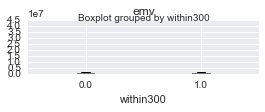

In [994]:
df.boxplot(column='emv', by='within300', figsize=(4,1))

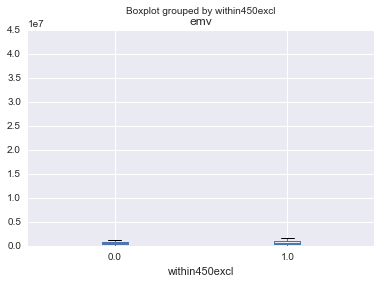

In [906]:
df.boxplot(column='emv',by='within450excl')

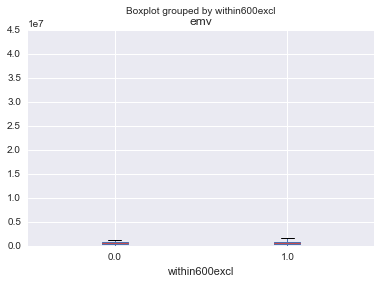

In [907]:
df.boxplot(column='emv', by='within600excl')

### So it looks as though proximity to a subway does make a difference in emv- the categorical variables will need to be incorporated into the final analysis

## Finally- some data cleaning and scrubbing before the final dataframe is ready

In [909]:
# rename some of the columns to be easier to process
df.rename(columns={'4 Year August Graduation Rate':'school_grad_rate','Crime Rate 2015':'crime_rate'},inplace=True)

In [729]:
# drop missing values
print df.crime_rate.isnull().sum()

24048


In [736]:
crimedrop=df[df.crime_rate.isnull]`

In [744]:
df=(df[df.crime_rate.notnull()])
# dropp all values where crime is null

In [747]:
print df.Med_Income.isnull().sum()

7525


In [748]:
missNTA=df[df.Med_Income.isnull()]

In [749]:
missNTA.censustract.value_counts()
# find the missing census tracts and explore why there's no corresponding NTA
# drop for now- explore later, if time, why they're missing

14605.0    1141
15602.0    1127
14608.0    1033
12805.0     811
30903.0     711
15802.0     588
13302.0     583
2001.0      430
30904.0     388
14202.0     243
4002.0      121
12902.0     106
6501.0       68
14402.0      61
502.0        20
15002.0      18
14802.0      13
91800.0       9
3602.0        9
14602.0       5
16002.0       1
27600.0       1
Name: censustract, dtype: int64

In [708]:
missNTA.Borough.value_counts()

SI    9083
QN    2125
BK     164
MN     110
BX       1
Name: Borough, dtype: int64

In [753]:
df=(df[df.Med_Income.notnull()])
# drop where not null where med_income/race

In [754]:
len(df)

531804

In [755]:
df.perc_white.isnull().sum()

0

In [777]:
df=df[df.emv.notnull()]
# drop rows where emv is null

In [782]:
df=(df[df.school_grad_rate.notnull()])
# drop null values in grad rate

In [786]:
# ensure no other missing values in the variables we care about
print df.isnull().sum()

Borough                         0
CT2010                          0
CB2010                         46
SchoolDist                      0
PolicePrct                      0
LandUse                         0
OwnerType                  508007
OwnerName                     735
LotArea                         0
BldgArea                        0
RetailArea                      0
NumFloors                       0
UnitsRes                        0
UnitsTotal                      0
IrrLotCode                      0
BsmtCode                        0
YearBuilt                       0
BuiltCode                   69724
HistDist                   516971
Landmark                   528441
BuiltFAR                        0
ResidFAR                        0
BoroCode                        0
BBL                             0
Tract2010                       0
bbl                             0
ownername                       0
address                         0
taxclass                        0
taxrate       

# And there we have it- a final dataframe, ready for analysis. While we'll run a couple of different models and regression types on it, the main independent variable to focus on will be the categorical subway walkshed variable, with other variables used as controls, in an attempt to predict emv (estimated market value) as the dependent variable

# Time for Analysis! (Note everything above this should've already been submitted as part of milestone 3, although there may have been some minor tweaks in this version- e.g. reformatted charts)

### Let's start out with a quick ANOVA check of the main independent variable, whether or not a parcel is in a subway walkshed. For simplicity, we'll just use whether it's within a 10-min walk or not, and control within each borough:

In [1011]:
anova=smf.ols(formula='emv ~ within600 + Borough', data=df).fit()

In [1013]:
anovatable=sm.stats.anova_lm(anova)
print pd.DataFrame(anovatable)

                 df        sum_sq       mean_sq             F         PR(>F)
Borough         4.0  1.177774e+17  2.944435e+16  85950.044467   0.000000e+00
within600       1.0  2.085055e+14  2.085055e+14    608.641828  2.632935e-134
Residual   528564.0  1.810729e+17  3.425751e+11           NaN            NaN


In [1014]:
pd.DataFrame(anovatable)

,df,sum_sq,mean_sq,F,PR(>F)
Borough,4.0,1.177774e+17,2.944435e+16,85950.044467,0.000000e+00
within600,1.0,2.085055e+14,2.085055e+14,608.641828,2.632935e-134
Residual,528564.0,1.810729e+17,3.425751e+11,NaN,NaN


In [1163]:
anova2=smf.ols(formula='emv ~ within300 + within450excl + within600excl + Borough', data=df).fit()
anovatable2=sm.stats.anova_lm(anova2)
pd.DataFrame(anovatable2)

,df,sum_sq,mean_sq,F,PR(>F)
Borough,4.0,1.177774e+17,2.944435e+16,85944.569301,0.000000e+00
within300,1.0,3.793012e+12,3.793012e+12,11.071355,8.767758e-04
within450excl,1.0,7.604393e+13,7.604393e+13,221.963246,3.454351e-50
within600excl,1.0,1.178184e+14,1.178184e+14,343.898020,9.558487e-77
Residual,528562.0,1.810837e+17,3.425969e+11,NaN,NaN


#### This suggests the strong significance of the within600 dummy variable for being within a walkshed. The next step is to create an initial multivariate regression, accounting for every potential variable, before fine tuning

In [763]:
# make sure that all of the linear model features and other sklearn features are incorporated
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

#### Now, I'll define my initial input independent variables as the following: Building area, school rates, crime rates, building age, median income, percent white, and then the following dummy variables: boroughs, hist district, landmark, and subway walksheds 

In [1038]:
modelsmf=smf.ols(formula='emv~ BldgArea + school_grad_rate + crime_rate + is_BK + is_BX + is_MN + is_QN + ishist + islandmark + buildingage + Med_Income + perc_white + within300 + within450excl + within600excl',data=df).fit()

In [1039]:
# First, let's show the summary with a statsmodels output
print modelsmf.summary()

                            OLS Regression Results                            
Dep. Variable:                    emv   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                 5.023e+04
Date:                Tue, 09 Aug 2016   Prob (F-statistic):               0.00
Time:                        23:22:33   Log-Likelihood:            -7.6678e+06
No. Observations:              528570   AIC:                         1.534e+07
Df Residuals:                  528554   BIC:                         1.534e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept          -1.339e+06   9229


#### It looks like all of the p values are significant, so will be a question of interpresting coefficients. Something with the within300 seems off- that one shouldn't be negative, and within600 shouldn't be higher than within450. I may just have to use a single binary within 10 minutes or not within 10 minutes, since there may not be enough points here; alternately, it could mean that when controlling for all else, being a few minutes away from a subway is actually better than right next to it

#### Most other variables perform as expected, the other interesting thing is that building age, while a small coefficient, actually contributes positively to value- this is likely one that has a non-linear effect


#### IF we re-do the model, but just with a simple binary subway variable, and with buildingage dropped, we get the following:

In [1050]:
modelsmf2=smf.ols(formula='emv~ BldgArea + school_grad_rate + crime_rate + is_BK + is_BX + is_MN + is_QN + ishist + islandmark + Med_Income + perc_white + within600',data=df).fit()

In [1051]:
print modelsmf2.summary()

                            OLS Regression Results                            
Dep. Variable:                    emv   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                 6.225e+04
Date:                Tue, 09 Aug 2016   Prob (F-statistic):               0.00
Time:                        23:41:44   Log-Likelihood:            -7.6691e+06
No. Observations:              528570   AIC:                         1.534e+07
Df Residuals:                  528557   BIC:                         1.534e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept          -1.253e+06   9106

#### So the r squared value is about the same, and the coefficients now all seem to make more sense...BUT we need to check for a few other things, so let's use sklearn to calculate the r squared value under a few other scenarios. We'll use the second model above going forward

In [1108]:
# defining X1, will use X1 first
X1=df[['BldgArea','school_grad_rate','crime_rate','is_BK','is_BX','is_MN','is_QN','ishist','islandmark','Med_Income','perc_white','within600']]
# y will always be the same
y=df.emv
X1_train,X1_test,y_train,y_test=train_test_split(X1,y,test_size=.33,random_state=50)
# make sure to split into testing and training set

In [1109]:
model_1=linear_model.LinearRegression()

In [1110]:
model_1.fit(X1_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1111]:
print model_1.coef_
print model_1.intercept_
print model_1.score(X1_train,y_train)
print model_1.score(X1_test,y_test)

[  2.88253879e+02   3.06019432e+05  -1.35356358e+03   5.18282138e+05
   3.80134435e+05   4.32837964e+06   3.94086943e+05   7.75445084e+05
   8.94465967e+05   9.72081595e+00   2.68705541e+05   2.94511228e+04]
-1242596.09376
0.584896937621
0.586664510622


In [ ]:
model_1pred=model_1.predict

#### Looks like the model performs fairly similarly across testing/training data

### The above model_1 is the same model, reproduced in sklearn, but with test/training data split- now let's see what altering intercepts or normalization will do to the model:

In [1112]:
model_2=linear_model.LinearRegression(fit_intercept=False)
model_2.fit(X1_train,y_train)
print X1.columns
print model_2.coef_
print model_2.intercept_
print model_2.score(X1_train,y_train)
model
print model_2.score(X1_test,y_test)

Index([u'BldgArea', u'school_grad_rate', u'crime_rate', u'is_BK', u'is_BX',
       u'is_MN', u'is_QN', u'ishist', u'islandmark', u'Med_Income',
       u'perc_white', u'within600'],
      dtype='object')
[  2.64904057e+02  -7.26002548e+05  -2.20168589e+04   4.63221446e+05
   2.28354100e+05   4.43816934e+06   3.18280072e+05   9.10818193e+05
   9.83658024e+05   7.21514626e+00   1.77350574e+05   3.27131047e+04]
0.0
0.570004519679
0.571917205828


### When we suppress the y intercept, the r squared value stays about the same, but the direction on the school graduation rate coefficient flips, while the magnitude of being within a subway walkshed increases slightly

In [1113]:
model_3=linear_model.LinearRegression(fit_intercept=False, normalize=True)
model_3.fit(X1_train,y_train)
print X1.columns
print model_3.coef_
print model_3.intercept_
print model_3.score(X1_train,y_train)
print model_3.score(X1_test,y_test)

Index([u'BldgArea', u'school_grad_rate', u'crime_rate', u'is_BK', u'is_BX',
       u'is_MN', u'is_QN', u'ishist', u'islandmark', u'Med_Income',
       u'perc_white', u'within600'],
      dtype='object')
[  2.64904057e+02  -7.26002548e+05  -2.20168589e+04   4.63221446e+05
   2.28354100e+05   4.43816934e+06   3.18280072e+05   9.10818193e+05
   9.83658024e+05   7.21514626e+00   1.77350574e+05   3.27131047e+04]
0.0
0.570004519679
0.571917205828


In [1114]:
model_4=linear_model.LinearRegression(normalize=True)
model_4.fit(X1_train,y_train)
print X1.columns
print model_4.coef_
print model_4.intercept_
print model_4.score(X1_train,y_train)
print model_4.score(X1_test,y_test)

Index([u'BldgArea', u'school_grad_rate', u'crime_rate', u'is_BK', u'is_BX',
       u'is_MN', u'is_QN', u'ishist', u'islandmark', u'Med_Income',
       u'perc_white', u'within600'],
      dtype='object')
[  2.88253879e+02   3.06019432e+05  -1.35356358e+03   5.18282138e+05
   3.80134435e+05   4.32837964e+06   3.94086943e+05   7.75445084e+05
   8.94465967e+05   9.72081595e+00   2.68705541e+05   2.94511228e+04]
-1242596.09376
0.584896937621
0.586664510622


### Meanwhile, turning normalization on/off doesn't appear to make a difference

## LASSO and RIDGE to correct

In [1167]:
model_5=linear_model.Lasso(alpha=.000001, fit_intercept=False)
model_5.fit(X1_train,y_train)
print X1.columns
print model_5.sparse_coef_
print model_5.intercept_
print model_5.score(X1_train,y_train)
print model_5.score(X1_test,y_test)

Index([u'BldgArea', u'school_grad_rate', u'crime_rate', u'is_BK', u'is_BX',
       u'is_MN', u'is_QN', u'ishist', u'islandmark', u'Med_Income',
       u'perc_white', u'within600'],
      dtype='object')
  (0, 0)	264.904056618
  (0, 1)	-726002.548412
  (0, 2)	-22016.8589459
  (0, 3)	463221.445801
  (0, 4)	228354.099924
  (0, 5)	4438169.33854
  (0, 6)	318280.071686
  (0, 7)	910818.193025
  (0, 8)	983658.020955
  (0, 9)	7.21514626348
  (0, 10)	177350.573665
  (0, 11)	32713.104716
0.0
0.570004519679
0.571917205828


### In playing with different alpha values above, it doesn't seem to make too much of a difference, the higher the alpha the lower the r squared, but not by a huge margin

In [1172]:
model_6=linear_model.Ridge(alpha=10000, normalize=True, fit_intercept=False)
model_6.fit(X1_train,y_train)
print X1.columns
print model_6.coef_
print model_6.intercept_
print model_6.score(X1_train,y_train)
print model_6.score(X1_test,y_test)

Index([u'BldgArea', u'school_grad_rate', u'crime_rate', u'is_BK', u'is_BX',
       u'is_MN', u'is_QN', u'ishist', u'islandmark', u'Med_Income',
       u'perc_white', u'within600'],
      dtype='object')
[  3.36625031e+02  -3.59634007e+05  -9.53604366e+03   4.96083648e+04
  -1.45047544e+05   8.25906421e+05  -3.03998049e+04   5.90239220e+05
   2.77883291e+04   5.68865799e+00   2.96725018e+04   1.48250401e+05]
0.0
0.402061441961
0.402097057045


### THe ridge model seems to be a little more sensitive- higher alpha values (esp >1) result in higher coefficients for the transit data set, albeit with lower r squared values

## Test against a dummy model

In [1154]:
NTAdums=pd.get_dummies(df.NTA)
list=NTAdums.columns
list=list[0:182]
NTAdums2=NTAdums[list]
XDum=pd.concat([NTAdums2,df.BldgArea,df.within600], axis=1)
DumModel=linear_model.LinearRegression()
Xdum_train,Xdum_test,ydum_train,ydum_test=train_test_split(XDum,y,test_size=.33,random_state=90)


In [1156]:
DumModel.fit(Xdum_train,ydum_train)
print DumModel.coef_
print DumModel.intercept_
print DumModel.score(Xdum_train,ydum_train)
print DumModel.score(Xdum_test,ydum_test)

[  3.56573686e+06   5.10542545e+04   6.68403119e+03  -9.78447739e+04
   4.42084909e+05   5.12213922e+04   2.27798969e+05   2.61955543e+05
   1.75769699e+05   2.99049309e+05   3.47587986e+05   1.52195976e+05
   1.20963195e+06   3.17276701e+05  -2.82399610e+04   1.23030438e+06
   1.32458908e+06   5.67467735e+05   1.72541763e+05   2.31473742e+05
   3.60285471e+05   1.60326010e+05   5.09215940e+04   3.86282270e+05
  -9.97636632e+04   1.96705980e+03   1.12226280e+05  -4.11844908e+04
   5.42654258e+04   1.05009554e+06   9.91624030e+05   4.53110330e+05
   1.00571361e+04   4.31927167e+05  -1.45514174e+03   2.37457140e+05
  -9.24904633e+04  -6.97837668e+04  -9.34433427e+04  -7.79958635e+04
  -8.69711966e+04  -1.03944128e+05  -7.43102379e+04   2.18277755e+05
   4.18539139e+05  -4.03752858e+04  -2.93084380e+05  -8.35770331e+04
  -1.06509138e+05  -2.31073590e+05  -1.22417454e+05  -2.01517382e+05
  -2.02911220e+05  -1.48172766e+05  -2.15333324e+05  -1.52022115e+05
  -2.58237894e+04  -8.30443067e+04

## Our dummy model, which just controls for building size, neighborhood, and binary within subway accounts for a higher r squared than the other more detailed model- suggests that there are various intangibles captured at the neighborhood level that are difficult to model; more/better data may be required